In [10]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter

In [83]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Downloads/CWOP_AP153.nc')
df = file.to_dataframe()
df = df.reset_index() # in order to grab the time information more easily -- would prefer not to do this
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year
df

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,tdps_derived,ps_derived,elevation,lat,lon,month,year
0,CWOP_AP153,2003-09-16 16:30:00,283.16,53.0,0.00,289.0,NaN,nan,nan,273.93,NaN,1406.0424,41.543,-120.5332,9,2003
1,CWOP_AP153,2003-09-16 17:00:00,284.83,44.0,0.90,263.0,NaN,nan,nan,272.88,NaN,1406.0424,41.543,-120.5332,9,2003
2,CWOP_AP153,2003-09-16 17:30:00,287.05,39.0,5.36,305.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
3,CWOP_AP153,2003-09-16 18:00:00,287.61,37.0,4.47,296.0,NaN,nan,nan,273.00,NaN,1406.0424,41.543,-120.5332,9,2003
4,CWOP_AP153,2003-09-16 18:30:00,288.72,35.0,3.13,254.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,CWOP_AP153,2005-03-08 18:00:00,281.49,66.0,0.00,247.0,86725.20,nan,nan,275.44,73203.68,1406.0424,41.543,-120.5332,3,2005
8931,CWOP_AP153,2005-03-08 18:15:00,282.61,62.0,0.00,342.0,86725.20,nan,nan,275.62,73203.68,1406.0424,41.543,-120.5332,3,2005
8932,CWOP_AP153,2005-03-08 18:30:00,283.72,60.0,0.00,224.0,86725.20,nan,nan,276.20,73203.68,1406.0424,41.543,-120.5332,3,2005
8933,CWOP_AP153,2005-03-08 20:15:00,290.38,35.0,0.90,349.0,86639.45,nan,nan,274.70,73131.30,1406.0424,41.543,-120.5332,3,2005


In [84]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [85]:
# identify the actual data vars
vars_to_remove = ['duration', 'method', 'lat', 'lon', 'elevation', 'qc', 'station', 'time', 'month', 'year']
[d for d in df.columns if not any(True for item in vars_to_remove if item in d)]

['tas', 'hurs', 'sfcWind', 'sfcWind_dir', 'tdps_derived', 'ps_derived']

In [86]:
def plot_gap_check(df, var):
    # plot histogram with count values against the standardized IQR
    num_bins = int(df[var].max()) + 1 - int(df[var].min())
    N = 10000 # what is this number - it matters!
    
    # standardize against IQR range
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    df_month_iqr = (df[var].values - df[var].median()) / iqr
    
    x = df_month_iqr
    plt.hist(x, bins=num_bins, alpha=0.3);
    xmin, xmax = plt.xlim()
    
    kur = stats.kurtosis(x, fisher=True)
    sk = stats.skew(x)

    # plot pdf
    if var == 'tas' or var == 'tdps' or var =='tdps_derived':
#         plt.xlim([-5,5])
        y = np.linspace(-5, 5, num_bins)
    else:
        y = np.linspace(xmin, xmax, num_bins)
    bin_width = (x.max() - x.min()) / num_bins
    plt.plot(y, stats.norm.pdf(y) * N * bin_width, color='k', lw=1)

    # add vertical lines to indicate thresholds -- clearly not correct
    pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y)))
    plt.axvline(x=y[stats.norm.pdf(y).tolist().index(pdf_idx[0])], color='r') # left tail
    plt.axvline(y[stats.norm.pdf(y).tolist().index(pdf_idx[-1])], color='r') # right tail
    
    plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('QA/QC Distributional gap for {0}: {1}'.format(df_month['station'].unique()[0], var));
    plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10);
    plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);
    plt.annotate('Skew: {}'.format(round(sk,3)), xy=(0.05,0.8), xycoords='axes fraction', fontsize=8)
    plt.annotate('Kurtosis: {}'.format(round(kur,3)), xy=(0.05, 0.75), xycoords='axes fraction', fontsize=8)
    plt.ylabel('Frequency (obs)')
    plt.xlabel('{} offset (IQR)'.format(var));
    
    # put AWS save figure stuffs here
    
    return

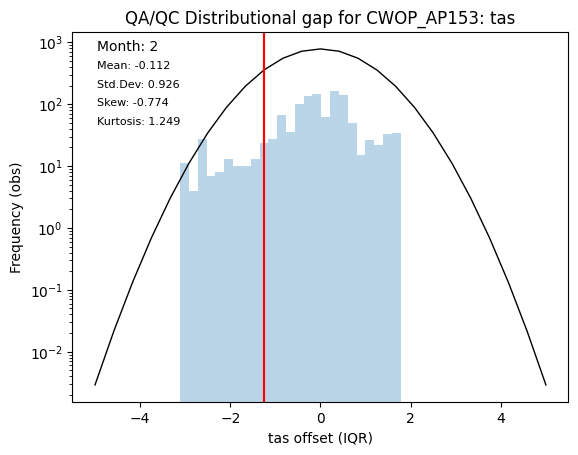

In [87]:
m = 2
df_month = df.loc[df['month'] == m]

plot_gap_check(df_month, var='tas')

In [88]:
# identifying where pdf curve is below 0.1 threshold

pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y).tolist()))
pdf_idx

NameError: name 'y' is not defined

In [89]:
def plot_gap_scatter(df, var):
    
    yr_list = df['time'].dt.year.unique().tolist()
    num_yrs = len(yr_list)
    if num_yrs > 5:
        num_yrs = 3 # select specific years?
        
#     fig, ax = plt.figure(figsize=(6,num_yrs*2+1))

    month_fmt = DateFormatter('%b')
    def m_fmt(x, pos=None):
        return month_fmt(x)[0]  
    
    for yr in yr_list:    
        ax = df.loc[df['time'].dt.year == yr].plot.scatter(x='time', y=var, figsize=(6,2), s=1, color='k', label='Pass') 
        # what to do if one year of data has all nan values -- ex: sensor was added later on?
        ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
        ax.set_xlim(pd.Timestamp(str(yr)+'-01-01'), pd.Timestamp(str(yr)+'-12-31'))
        ax.set_ylim(int(df[var].min()), int(df[var].max())+1)
        ax.set_xlabel(yr) # for now
        
        # flagged/suspicious data in different color - need to overlap, not new axis
#         bad_vals = df.loc[df[var+'_eraqc'] == FLAG]
#         ax = bad_vals.loc[bad_vals['time'].dt.yar == yr].plot.scatter(x='time', y=var, s=1, color='r', label='Flagged')


    # modify so that legend only appears once
    # legend item text size small, 2 cols


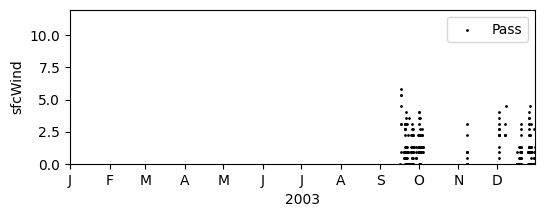

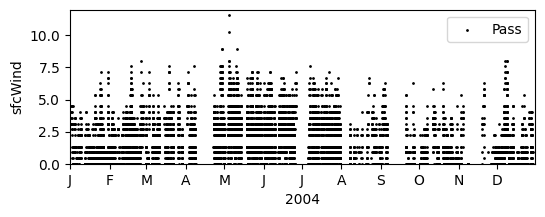

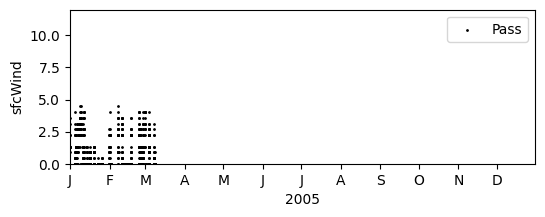

In [90]:
plot_gap_scatter(df, var='sfcWind')

In [ ]:
## part 1
## compare anomalies of monthly median values

# standardize against interquartile range, and compare stepwise from the middle of the distribution outwards
# asymmetries are identified and flagged if severe

# this would flag at the monthly level -- is this even useful for us? would flag bad months as a whole
# could use to analyze that month in particular?

In [109]:
# calculate monthly medians
var = 'tas'
df_anom = df.sub(df.resample('M', on='time').transform('median', numeric_only=True))

# DONE PER VARIABLE NOW
# standardize against IQR range, needs to be by calendar month ---- FIX
q1 = df_anom[var].quantile(0.25)
q3 = df_anom[var].quantile(0.75)
iqr = q3 - q1
df_month_iqr = df_anom[var] / iqr # s_ij

# "inflated to 4°C or hPa for those months with very small IQR"
# accounts for any seasonal cycle in variance
small_iqr_var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter', 'ps_derived']
if var in small_iqr_var_check:
    print('small var check')
    if (np.abs(df_month_iqr.iloc[-1]) + np.abs(df_month_iqr.iloc[0])) < 4:
        df_month_iqr = np.linspace(-2, 2, len(df))

# standardized anomalies are ranked (not necessary?) and calculate median
# standardized anomaly median
std_med = np.nanmedian(df_month_iqr) # will be 0 if inflated to range of 4
print(std_med)

small var check
0.0


In [107]:
df_month_iqr

0      -0.502793
1       0.000000
2       2.491620
3       1.994413
4       1.245810
          ...   
8930    0.000000
8931    0.000000
8932    0.000000
8933    0.502793
8934    0.000000
Name: sfcWind, Length: 8935, dtype: float64

In [99]:
np.where(np.abs(df_month_iqr + std_med) > 1)

(array([   0,    1,    2, ..., 8932, 8933, 8934]),)

In [108]:
df_month_iqr.index[np.abs(df_month_iqr + std_med) > 1].tolist()

[2,
 3,
 4,
 5,
 6,
 7,
 14,
 16,
 20,
 30,
 35,
 36,
 51,
 58,
 83,
 104,
 105,
 109,
 110,
 133,
 151,
 155,
 156,
 157,
 159,
 161,
 167,
 168,
 209,
 211,
 219,
 220,
 227,
 229,
 232,
 233,
 234,
 243,
 264,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 304,
 306,
 309,
 310,
 324,
 326,
 327,
 328,
 330,
 331,
 332,
 333,
 368,
 370,
 378,
 380,
 382,
 393,
 394,
 395,
 402,
 404,
 406,
 446,
 447,
 448,
 449,
 450,
 451,
 470,
 471,
 527,
 564,
 565,
 639,
 640,
 641,
 642,
 643,
 645,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 682,
 683,
 705,
 711,
 796,
 798,
 801,
 802,
 803,
 804,
 805,
 806,
 808,
 809,
 810,
 811,
 812,
 813,
 814,
 815,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 828,
 829,
 830,
 831,
 832,
 833,
 834,
 835,
 836,
 837,
 849,
 850,
 851,
 893,
 894,
 895,
 899,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1046,
 1047,
 1049,
 1050,
 1051,
 1052,
 1053,
 1054,
 1055,
 1056

In [69]:
# flag all obs in any month/year if standardized anom is +/- 5 from std_med
# currently requires that dataframe is in the correct original order -- FIX/ENSURE NOT AN ISSUE

iqr5_check = df_month_iqr[np.abs(df_month_iqr + std_med) > 5].index.tolist() # only works on non-small var check vars
print(len(iqr5_low_check)) # testing

if len(iqr5_check) > 1: # returns indices where fails
    print('Distribution gap check part 1 start') # testing
    # identify each index for variable appropriately + THE ENTIRE SURROUNDING MONTH
    for idx in iqr5_check:
        bad_yr = df.iloc[df.index == idx]['year'].values[0]
        bad_mon = df.iloc[df.index == idx]['month'].values[0]
        print('Bad month-year: {0}-{1}'.format(bad_mon, bad_yr))
        bad_obs_per_month = df.loc[(df['year'] == bad_yr) & (df['month'] == bad_mon)]
        
        # flag values
        all_idx_to_flag = bad_obs_per_month.index
        
        for i in all_idx_to_flag:
            df.loc[df.index == i, var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv # DOUBLE CHECK VALUE
            
        print(str(len(bad_obs_per_month)) + " obs fail check")
    
else:
    print('all pass') # all obs are within +/- 5 IQR range


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [67]:
df

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,tdps_derived,ps_derived,elevation,lat,lon,month,year
0,CWOP_AP153,2003-09-16 16:30:00,283.16,53.0,0.00,289.0,NaN,nan,nan,273.93,NaN,1406.0424,41.543,-120.5332,9,2003
1,CWOP_AP153,2003-09-16 17:00:00,284.83,44.0,0.90,263.0,NaN,nan,nan,272.88,NaN,1406.0424,41.543,-120.5332,9,2003
2,CWOP_AP153,2003-09-16 17:30:00,287.05,39.0,5.36,305.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
3,CWOP_AP153,2003-09-16 18:00:00,287.61,37.0,4.47,296.0,NaN,nan,nan,273.00,NaN,1406.0424,41.543,-120.5332,9,2003
4,CWOP_AP153,2003-09-16 18:30:00,288.72,35.0,3.13,254.0,NaN,nan,nan,273.22,NaN,1406.0424,41.543,-120.5332,9,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,CWOP_AP153,2005-03-08 18:00:00,281.49,66.0,0.00,247.0,86725.20,nan,nan,275.44,73203.68,1406.0424,41.543,-120.5332,3,2005
8931,CWOP_AP153,2005-03-08 18:15:00,282.61,62.0,0.00,342.0,86725.20,nan,nan,275.62,73203.68,1406.0424,41.543,-120.5332,3,2005
8932,CWOP_AP153,2005-03-08 18:30:00,283.72,60.0,0.00,224.0,86725.20,nan,nan,276.20,73203.68,1406.0424,41.543,-120.5332,3,2005
8933,CWOP_AP153,2005-03-08 20:15:00,290.38,35.0,0.90,349.0,86639.45,nan,nan,274.70,73131.30,1406.0424,41.543,-120.5332,3,2005


In [66]:
df.loc[df['sfcWind_dir_eraqc'] == 18]

KeyError: 'sfcWind_dir_eraqc'

In [57]:
8935 - 8896

39